In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")
camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [2]:
class FactsOrAnalysisDS_BERT(Dataset):
    """PyTorch Dataset class. Returns input-target tensor pairs"""
    def __init__(self,csv_file,model):
        with open(csv_file) as f:
            dataset=[line.split(",") for line in f]
        self.dataset=[[camembert.encode(datum[0]),int(datum[1][0])] for datum in dataset]
    
    def __len__(self):
        return (len(self.dataset))
    
    def __getitem__(self,index):
        return self.dataset[index]

In [3]:
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn

## FIRST EXPERIMENT: camemBERT as embeddings model that feeds into a GRU network

## Originally a combination of the output of a GRU network and a CNN, I am now replacing
## the architecture to include a BERT model whose output is fed into a recurrent layer

class FactsOrAnalysis_camemBERT(nn.Module):
    def __init__(self,hidden_size=128):
        super(FactsOrAnalysis_camemBERT, self).__init__()
        camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')
        self.camembert=camembert
        self.gru=torch.nn.GRU(
            input_size=768,
            hidden_size=hidden_size,
            num_layers=3,
            batch_first=True,
            bidirectional=True)
        self.linear = nn.Linear(hidden_size,1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self,input_tensor, lengths=None):
        output=self.camembert.extract_features(input_tensor)
        if lengths is not None:
            output=torch.nn.utils.rnn.pack_padded_sequence(output, 
                                                               lengths, 
                                                               batch_first=True, 
                                                               enforce_sorted=True)
        _,output=self.gru(output) # output here catches the hidden state
#         if lengths is not None:
#             output = padd_packed_seq(out)
        output=output[0]
        output=self.linear(output)
#         output=self.softmax(output)
#         print(output)
        return self.softmax(output)

In [4]:
class PadSequence:
    def __call__(self,batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [x[0] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
        lengths = torch.Tensor([len(x) for x in sequences])
        labels = torch.Tensor([x[1] for x in sorted_batch])
        return sequences_padded, labels, lengths

In [5]:
import torch,IPython,numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

def train(input_tensor,target,model,optimiser,criterion,clip,lengths):
    model.train()
    optimiser.zero_grad()
    prediction = model(input_tensor,lengths=lengths).to(device)
    loss = criterion(prediction,target)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
    optimiser.step()
    return loss.item(), prediction

def valid(input_tensor,target,model,criterion,lengths):
    model.eval()
    prediction = model(input_tensor,lengths=lengths)
    loss = criterion(prediction,target)
    return loss.item(), prediction

def test(target_tensor,prediction_tensor):
    t = target_tensor.cpu().detach().numpy()
    t = np.array([target for target in t])
    
    p = prediction_tensor.cpu().detach().numpy()
    p = np.array([predic for predic in p])
    p = p.round()
            
    return accuracy_score(t,p), f1_score(t,p), precision_score(t,p), recall_score(t,p)

def trainIters(model,
               train_dset,
               valid_dset,
               batch_size,
               n_epochs,
               learning_rate,
               weight_decay,
               clip,
               collate_fn=None):
    
    print("CUDA is available!" if torch.cuda.is_available() else "NO CUDA 4 U")
    
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = torch.nn.BCELoss()
    
    train_dl=torch.utils.data.DataLoader(train_dset, batch_size=batch_size,collate_fn=collate_fn)
    valid_dl=torch.utils.data.DataLoader(valid_dset, batch_size=batch_size,collate_fn=collate_fn)
    
    train_losses=[np.inf]
    valid_losses=[np.inf]
    train_f1=0
    valid_f1=0
    tqdm_range=tqdm(range(1,n_epochs+1),desc='Epoch',leave=False)
    for epoch in tqdm_range:
        
        #################################
        ### STUFF RELATED TO PLOTTING ###
        #################################
        plt.gca().cla()
        plt.xlim(0,n_epochs)
        plt.ylim(0,2)
        plt.title("Learning curve")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.text(n_epochs/2,1.9,"Train loss: {:.2f}".format(train_losses[-1]))
        plt.text(n_epochs/2,1.8,"Validation loss: {:.2f}".format(valid_losses[-1]))
        plt.text(n_epochs/2,1.7,"Training F1: {:.2f}".format(train_f1))
        plt.text(n_epochs/2,1.6,"Validation F1: {:.2f}".format(valid_f1))
        plt.plot(train_losses, "-b", label="Training loss")
        plt.plot(valid_losses, "-r", label="Validation loss")
        plt.legend(loc="upper left")
        IPython.display.display(plt.gcf())
        ########################################
        ### END OF STUFF RELATED TO PLOTTING ###
        ########################################
        avg_train=[]
        train_f1=[]
        train_dl=tqdm(train_dl,desc='Training',leave=False)
        
#         for i in train_dl:
#             print(i[0],i[1],i[2])
    
        for x,y,lengths in train_dl:
            input_tensor = x.to(device)
            target = y.to(device)
            train_loss, prediction = train(input_tensor,
                                           target,
                                           model,
                                           optimiser,
                                           criterion,
                                           clip,
                                           lengths)
            accuracy,f1,precision,recall=test(target,prediction)
            avg_train.append(train_loss)
            train_f1.append(f1)
            train_dl.set_description('Training accuracy: {:.4f}'.format(accuracy))
        avg_train=sum(avg_train)/len(avg_train)
        train_f1=sum(train_f1)/len(train_f1)
        
        train_losses.append(avg_train)
        print(avg_train)
        
        with torch.no_grad():
            avg_valid=[]
            valid_f1=[]
            valid_dl=tqdm(valid_dl,desc='Validating',leave=False)
            for x, y,lengths in valid_dl:
                input_tensor = x.to(device)
                target = y.to(device)
                v_loss, valid_pred = valid(input_tensor,
                                           target,
                                           model,
                                           criterion,
                                           lengths)
                accuracy,f1,precision,recall=test(target,valid_pred)
                avg_valid.append(v_loss)
                valid_f1.append(f1)
                valid_dl.set_description('Validation accuracy: {:.4f}'.format(accuracy))
            avg_valid=sum(avg_valid)/len(avg_valid)
            valid_f1=sum(valid_f1)/len(valid_f1)
            valid_losses.append(v_loss)
            print(v_loss)
            
        IPython.display.clear_output(wait=True)
        tqdm_range.refresh()
    
    return train_losses,valid_losses

In [6]:
train_ds="data/train_data.csv"
valid_ds="data/valid_data.csv"

train_ds=FactsOrAnalysisDS_BERT(train_ds,model=camembert)
valid_ds=FactsOrAnalysisDS_BERT(valid_ds,model=camembert)

Using cache found in /home/andres/.cache/torch/hub/pytorch_fairseq_master
Using cache found in /home/andres/.cache/torch/hub/pytorch_fairseq_master


In [7]:
train_ds=train_ds[:100]
valid_ds=valid_ds[:100]

In [8]:
model=FactsOrAnalysis_camemBERT().to(device)

Using cache found in /home/andres/.cache/torch/hub/pytorch_fairseq_master


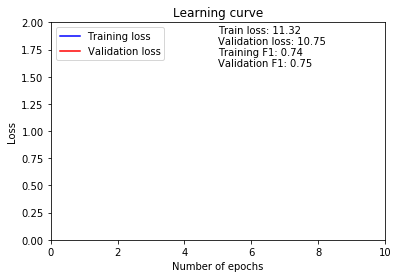

In [9]:
## CONFIG
batch_size=64
n_epochs=10
learning_rate=1e-3
weight_decay=0
clip=.2
## /CONFIG

t,v=trainIters(model,
               train_ds,
               valid_ds,
               batch_size,
               n_epochs,
               learning_rate,
               weight_decay,
               clip,
              collate_fn=PadSequence())

In [11]:
t,v

([inf,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525,
  11.321043491363525],
 [inf,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707,
  10.745396614074707])